In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/ruyogagp/medical_interpretability')
import numpy as np
from pysurvival.models import BaseModel
from pysurvival import utils
import scipy
import pandas as pandas
import copy
import random
from sklearn.preprocessing import StandardScaler
from source.utils import create_correlated_var
from pysurvival.models.simulations import SimulationModel
from lifelines import CoxPHFitter
import pandas as pd

In [3]:
import networkx as nx
from cga import cga
from itertools import cycle
import tqdm as tqdm

## Helper Functions

In [4]:
def _sample_random_data(N):
    """
    Generating a array of size N from a random distribution -- the available
    """
    index = np.random.binomial(n = 4, p = 0.5)
    distributions = {
        'binomial_a': np.random.binomial(n = 20, p = 0.6, size = N ),
        'binomial_b': np.random.binomial(n = 200, p = 0.6, size = N ),
        'chisquare': np.random.chisquare(df = 10, size = N ),
        'exponential_a': np.random.exponential(scale=0.1, size = N ),
        'exponential_b': np.random.exponential(scale=0.01, size = N ),
        'gamma': np.random.gamma(shape=2., scale=2., size = N ),
        'normal_a': np.random.normal(loc=-1.0, scale=5.0, size=N ),
        'normal_b': np.random.normal(loc=10.0, scale=10.0, size=N ),
        'uniform_a': np.random.uniform(low=-2.0, high=10.0, size=N ),
        'uniform_b': np.random.uniform(low=-20.0, high=100.0, size=N ),
        'laplace': np.random.laplace(loc=0.0, scale=1.0, size=N )
    }

    list_distributions = copy.deepcopy(list(distributions.keys()))
    random.shuffle(list_distributions)
    key = list_distributions[ index ]
    return key, distributions[key]

def fit_coxph(df):
    cph = CoxPHFitter()
    cph.fit(df, 'time', 'event')
    cph.print_summary()

def fit_coxph_norm(df):
    standard_scaler = StandardScaler()
    for col in df.columns:
        if col == 'time' or col == 'event':
            pass
        df[col] = standard_scaler.fit_transform(df[[col]])
    cph = CoxPHFitter()
    cph.fit(df, 'time', 'event')
    cph.print_summary()

## Simulation Model with correlations

In [182]:
class SimulationModelWithCorrelations(SimulationModel):
    """
    Subclasses `SimulationModel` to generated data from an predefined
    risk factor.
    """

    def generate_data(self,
                      df: pd.DataFrame,
                      feature_weights: list,
                      feature_names: list,
                      ):

        def risk_function(x_std, feature_weights):
            """ Calculating the risk function based on the given risk type """

            # Dot product
            risk = np.dot(x_std, feature_weights )

            # Choosing the type of risk
            if self.risk_type.lower() == 'linear' :
                return risk.reshape(-1, 1)

            elif self.risk_type.lower() == 'square' :
                risk = np.square(risk*self.risk_parameter)


            elif self.risk_type.lower() == 'gaussian' :
                risk = np.square(risk)
                risk = np.exp( - risk*self.risk_parameter)

            return risk.reshape(-1, 1)

        input_data = df.loc[:, feature_names].to_numpy()
        self.dataset = copy.deepcopy(df)
        num_samples = input_data.shape[0]
        X_std = self.scaler.fit_transform(input_data)
        BX = risk_function(X_std, feature_weights)

        # Building the survival times
        T = self.time_function(BX)
        C = np.random.normal(loc=self.censored_parameter, scale=5, size=num_samples)
        C = np.maximum(C, 0.0)
        time = np.minimum(T, C)
        E = 1.0 * (T == time)

        # Building dataset
        self.dataset = copy.deepcopy(df)
        self.dataset['time'] = time
        self.dataset['event'] = E
        self.dataset['hazard'] = BX

        # Building the time axis and time buckets
        self.times = np.linspace(0.0, max(self.dataset["time"]), self.bins)
        self.get_time_buckets()

        # Building baseline functions
        self.baseline_hazard = self.hazard_function(self.times, 0)
        self.baseline_survival = self.survival_function(self.times, 0)

        # Printing summary message
        message_to_print = "Number of data-points: {} - Number of events: {}"
        print(message_to_print.format(num_samples, sum(E)))
        return self.dataset

## Correlation Case Graph

In [183]:
@cga.node
def correlate(x: float, noise:float) -> float:
    """
    :param x: exisiting data to correlate
    :param coeff: correlation coefficient
    :param noise: noise variable
    :return: variable correlated by coeff to the exisiting variable x
    """
    correlate = create_correlated_var(x, mu=np.mean(x), sd=np.std(x), empirical=False, r=-0.75)
    return correlate + noise

@cga.node
def sample_random_normal(noise:float)->float:
    """
    :param n: sample size
    :param noise: noise variable
    :return: random normal variable
    """
    return np.random.normal(size=10) + noise

@cga.node
def correlation_coefficient(coeff:float) -> float:
    return coeff

class CorrelationCaseGraph(cga.Graph):
    def __init__(self):
        """
        causal graph for correlation case
        :param n: number of data points
        :param coeff: desired correlation coefficient between the two variables
        """
        # self.corr_coeff = correlation_coefficient(coeff, name='coeff')
        noise = cga.node(lambda: np.random.normal(scale=0.05, size=10))
        self.noise_x = noise(name="noise_x")
        self.noise_y = noise(name="noise_y")
        self.x = sample_random_normal(self.noise_x, name='x')
        self.y = correlate(self.x, self.noise_y, name='correlate')
        super().__init__([self.x, self.y])

    def get_interventions(self,
                          sim: SimulationModelWithCorrelations,
                          n_samples: int,
                          feature_weights: list,
                          ) -> pd.DataFrame:
        data = None
        for node in [self.noise_x, self.noise_y]:
            for _ in tqdm.auto.trange(n_samples, desc=f"Intervention {node.name}"):
                # resample noise
                orig, intervention = self.sample_do(action=cga.Resample(node))
                row = {'modified_attribute': [node.name] * 10}
                # add orig + do to the dictionary
                row.update({
                    n.name + "_orig": v
                    for n, v in orig.items()
                })
                row.update({
                    n.name + "_do": v
                    for n, v in intervention.items()
                })

                data = row if data is None else data
                for key in row.keys():
                    row[key] = row[key].tolist() if isinstance(row[key], np.ndarray) else row[key]
                    data[key].extend(row[key])
        df = pd.DataFrame(data)

        orig_cols = ['x_orig', 'correlate_orig']
        orig_df = sim.generate_data(df, feature_names=orig_cols,
                                    feature_weights=feature_weights)
        df['event_orig'] = orig_df.event
        df['time_orig'] = orig_df.time

        do_cols = ['x_do', 'correlate_do']
        do_df = sim.generate_data(df, feature_names=do_cols,
                                  feature_weights=feature_weights)
        df['event_do'] = do_df.event
        df['time_do'] = do_df.time
        return df

## Simulation Model

In [188]:
correlation_graph = CorrelationCaseGraph()
feature_weights = [np.log(2), np.log(1.5)]
sim = SimulationModelWithCorrelations(risk_type='linear', alpha=1.0, beta=5.0, censored_parameter=5.0, survival_distribution='weibull')
df = correlation_graph.get_interventions(sim=sim,
                                                   n_samples=2000,
                                                   feature_weights=feature_weights)

Intervention noise_x:   0%|          | 0/2000 [00:00<?, ?it/s]

Intervention noise_y:   0%|          | 0/2000 [00:00<?, ?it/s]

Number of data-points: 40010 - Number of events: 31755.0
Number of data-points: 40010 - Number of events: 31713.0


<AxesSubplot:xlabel='x', ylabel='y'>

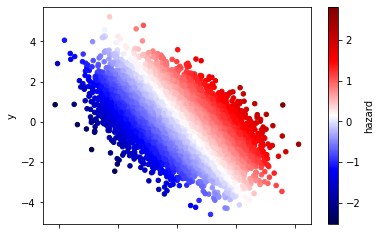

In [118]:
result.plot.scatter('x', 'y', c='hazard', colormap='seismic')

<AxesSubplot:xlabel='x', ylabel='hazard'>

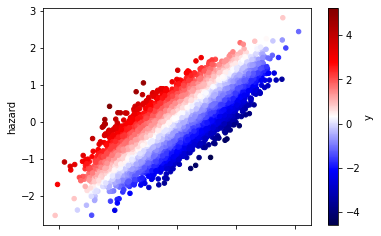

In [119]:
result.plot.scatter('x', 'hazard', c='y', colormap='seismic')

<AxesSubplot:xlabel='y', ylabel='hazard'>

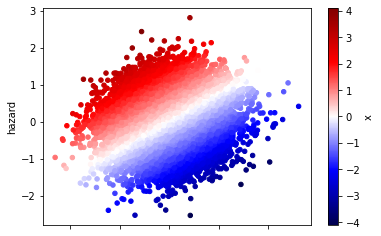

In [120]:
result.plot.scatter('y', 'hazard', c='x', colormap='seismic')